In [1]:
# Import necessary libraries
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Data augmentation and preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet requires 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ResNet normalization
])

# Prepare dataset
spectrogram_base_path_train = r'C:\Users\user\Desktop\birdclef-2022\spectrograms_train'

# Assuming you're using ImageFolder or a custom dataset
train_dataset = datasets.ImageFolder(spectrogram_base_path_train, transform=transform)

# Split dataset into training and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

print("DataLoaders for ResNet (train and validation) are ready.")

DataLoaders for ResNet (train and validation) are ready.


In [3]:
# Define path to test spectrograms
spectrogram_base_path_test = r'C:\Users\user\Desktop\birdclef-2022\spectrograms_test'

# Create the test dataset
test_dataset = datasets.ImageFolder(spectrogram_base_path_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("DataLoader for test data is ready.")

DataLoader for test data is ready.


In [4]:
# Load pre-trained ResNet50 model using the updated 'weights' argument
weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)

# Modify the final layer to match the number of classes (5 bird species in this case)
num_classes = 5
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet.to(device)

print("ResNet model loaded and modified for bird species classification.")

ResNet model loaded and modified for bird species classification.


In [5]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss
optimizer = optim.Adam(resnet.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

print("Loss function and optimizer are defined.")

Loss function and optimizer are defined.


Epoch [1/10], Train Loss: 1.2107, Val Loss: 2.3759
Epoch [2/10], Train Loss: 0.6121, Val Loss: 0.9574
Epoch [3/10], Train Loss: 0.3272, Val Loss: 0.7599
Epoch [4/10], Train Loss: 0.1850, Val Loss: 1.5868
Epoch [5/10], Train Loss: 0.2497, Val Loss: 0.7523
Epoch [6/10], Train Loss: 0.1245, Val Loss: 0.5422
Epoch [7/10], Train Loss: 0.1563, Val Loss: 0.5133
Epoch [8/10], Train Loss: 0.1214, Val Loss: 0.5662
Epoch [9/10], Train Loss: 0.0671, Val Loss: 0.3992
Epoch [10/10], Train Loss: 0.0246, Val Loss: 0.3655


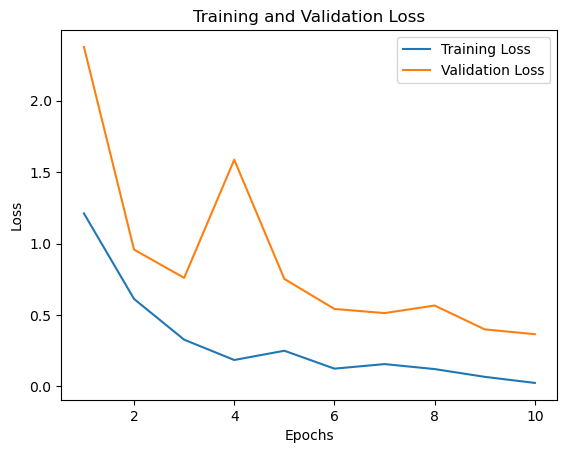

In [6]:
# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop
num_epochs = 10
best_val_loss = float('inf')  # To track the best validation loss

for epoch in range(num_epochs):
    # Set model to training mode
    resnet.train()
    running_loss = 0.0

    # Training step
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Reset gradients
        outputs = resnet(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    resnet.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(resnet.state_dict(), 'best_resnet_model.pth')

# Plot training and validation losses
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

ResNet Model - Accuracy: 0.9119
ResNet Model - Precision: 0.9146
ResNet Model - Recall: 0.9119
ResNet Model - F1 Score: 0.9127


<Figure size 1000x800 with 0 Axes>

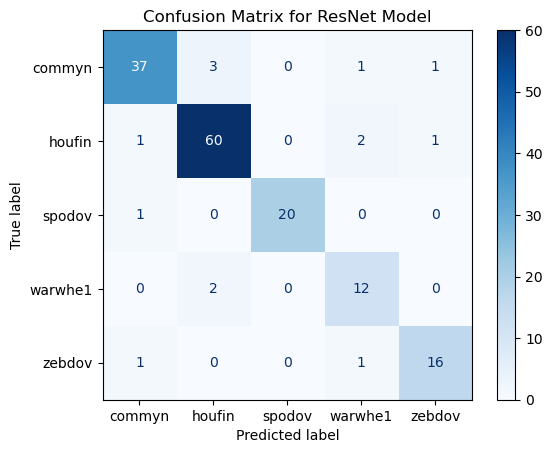

In [7]:
# Evaluate the ResNet model on the test dataset
resnet.eval()  # Set the model to evaluation mode

all_labels = []
all_preds = []

# Iterate over the test data
with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = resnet(inputs)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Get predicted labels
        
        all_labels.extend(labels.cpu().numpy())  # Collect true labels
        all_preds.extend(preds.cpu().numpy())  # Collect predicted labels

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

# Print the metrics
print(f"ResNet Model - Accuracy: {accuracy:.4f}")
print(f"ResNet Model - Precision: {precision:.4f}")
print(f"ResNet Model - Recall: {recall:.4f}")
print(f"ResNet Model - F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for ResNet Model')
plt.show()

## Improved model

In [8]:
# Define early stopping parameters
patience = 5  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Initialize with infinity
early_stop_counter = 0  # To keep track of early stopping patience

In [9]:
# Improved data augmentation and preprocessing
improved_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet requires 224x224 images
    transforms.RandomHorizontalFlip(),  # Random horizontal flips
    transforms.RandomRotation(10),  # Random rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Brightness and color adjustments
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet
])

# Create new dataset with improved augmentation
train_dataset = datasets.ImageFolder(spectrogram_base_path_train, transform=improved_transform)

# Same data splitting as before
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

In [13]:
# Define the loss function and optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)  # Added weight decay (L2 regularization)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)  # Learning rate scheduler

print("Loss function, optimizer, and learning rate scheduler are defined.")

Loss function, optimizer, and learning rate scheduler are defined.


Epoch [1/30], Train Loss: 0.1625, Val Loss: 0.2581
Epoch [2/30], Train Loss: 0.1183, Val Loss: 0.2288
Epoch [3/30], Train Loss: 0.1455, Val Loss: 0.2570
Epoch [4/30], Train Loss: 0.1235, Val Loss: 0.2347
Epoch [5/30], Train Loss: 0.1031, Val Loss: 0.2150
Epoch [6/30], Train Loss: 0.1018, Val Loss: 0.2454
Epoch [7/30], Train Loss: 0.0918, Val Loss: 0.2487
Epoch [8/30], Train Loss: 0.0928, Val Loss: 0.2065
Epoch [9/30], Train Loss: 0.0824, Val Loss: 0.1768
Epoch [10/30], Train Loss: 0.0704, Val Loss: 0.2270
Epoch [11/30], Train Loss: 0.0768, Val Loss: 0.1759
Epoch [12/30], Train Loss: 0.0967, Val Loss: 0.1529
Epoch [13/30], Train Loss: 0.0935, Val Loss: 0.1986
Epoch [14/30], Train Loss: 0.0790, Val Loss: 0.2016
Epoch [15/30], Train Loss: 0.0869, Val Loss: 0.2002
Epoch [16/30], Train Loss: 0.0708, Val Loss: 0.1770
Epoch [17/30], Train Loss: 0.0880, Val Loss: 0.2019
Early stopping triggered.


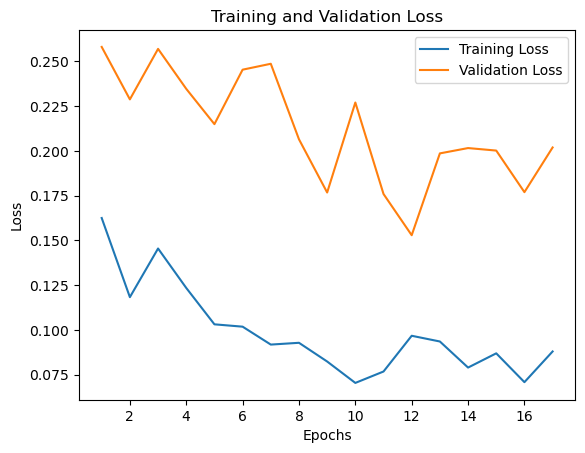

In [14]:
# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop with early stopping, data augmentation, L2 regularization, and learning rate scheduling
num_epochs = 30  # Increase the number of epochs
early_stop_counter = 0  # Initialize early stopping counter

for epoch in range(num_epochs):
    # Set model to training mode
    resnet.train()
    running_loss = 0.0

    # Training step
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = resnet(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    resnet.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Learning rate scheduler
    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(resnet.state_dict(), 'best_resnet_model.pth')  # Save the best model
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Improved ResNet Model - Accuracy: 0.9308
Improved ResNet Model - Precision: 0.9311
Improved ResNet Model - Recall: 0.9308
Improved ResNet Model - F1 Score: 0.9296


<Figure size 1000x800 with 0 Axes>

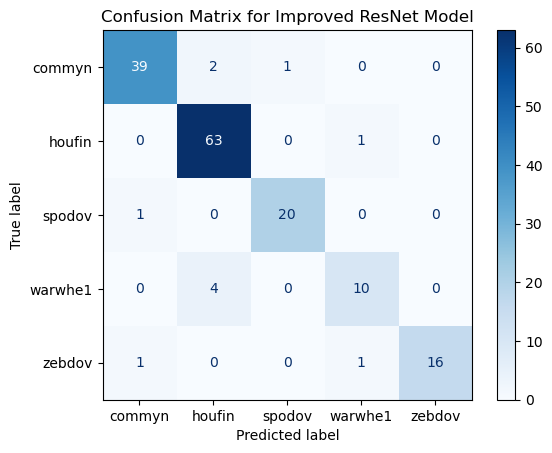

In [15]:
# Load the best model from training
resnet.load_state_dict(torch.load('best_resnet_model.pth'))

# Set the model to evaluation mode
resnet.eval()

# Lists to store all true labels and predictions
all_labels = []
all_preds = []

# Evaluate the model on the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

# Print the metrics
print(f"Improved ResNet Model - Accuracy: {accuracy:.4f}")
print(f"Improved ResNet Model - Precision: {precision:.4f}")
print(f"Improved ResNet Model - Recall: {recall:.4f}")
print(f"Improved ResNet Model - F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Improved ResNet Model')
plt.show()
